In [58]:
# -*- coding: utf-8 -*-

import numpy as np
from pandas import concat
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

https://blog.csdn.net/qq_45077760/article/details/124508235?ops_request_misc=&request_id=&biz_id=102&utm_term=bp%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9Cpython&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduweb~default-7-124508235.nonecase&spm=1018.2226.3001.4187


In [59]:
# 使用前400个点的 speed & power 预测接下来 4h(4h/15min) 的power
n_back = 400
n_out = 16
n_pre = n_out*15*2
n_feature = 2
# 使用前6天的数据进行训练
train_len = 4
# 神经网络参数
units = 100
rounds = 100
size = 72

In [60]:
'''
BP神经网络Python实现
'''

import random
import numpy as np


def sigmoid(x):
    '''
    激活函数
    '''
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

class BPNNRegression:
    '''
    神经网络回归与分类的差别在于：
    1. 输出层不需要再经过激活函数
    2. 输出层的 w 和 b 更新量计算相应更改
    '''
    def __init__(self, sizes):

        # 神经网络结构
        self.num_layers = len(sizes)
        self.sizes = sizes

        # 初始化偏差，除输入层外， 其它每层每个节点都生成一个 biase 值（0-1）
        self.biases = [np.random.randn(n, 1) for n in sizes[1:]]
        # 随机生成每条神经元连接的 weight 值（0-1）
        self.weights = [np.random.randn(r, c)
                        for c, r in zip(sizes[:-1], sizes[1:])]
        
    def feed_forward(self, a):
        '''
        前向传输计算输出神经元的值
        '''
        for i, b, w in zip(range(len(self.biases)), self.biases, self.weights):
            # 输出神经元不需要经过激励函数
            if i == len(self.biases) - 1:
                a = np.dot(w, a) + b
                break
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def MSGD(self, training_data, epochs, mini_batch_size, eta, error = 0.01):
        '''
        小批量随机梯度下降法
        '''
        n = len(training_data)
        for j in range(epochs):
            # 随机打乱训练集顺序
            random.shuffle(training_data)
            # 根据小样本大小划分子训练集集合
            mini_batchs = [training_data[k:k+mini_batch_size]
                            for k in range(0, n, mini_batch_size)]
            # 利用每一个小样本训练集更新 w 和 b
            for mini_batch in mini_batchs:
                self.updata_WB_by_mini_batch(mini_batch, eta)
            
            #迭代一次后结果
            err_epoch = self.evaluate(training_data)
            print("Epoch {0} Error {1}".format(j, err_epoch))
            if err_epoch < error:
                break
            # if test_data:
            #     print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
            # else:
            # print("Epoch {0}".format(j))
        return err_epoch
    
    def updata_WB_by_mini_batch(self, mini_batch, eta):
        '''
        利用小样本训练集更新 w 和 b
        mini_batch: 小样本训练集
        eta: 学习率
        '''
        # 创建存储迭代小样本得到的 b 和 w 偏导数空矩阵，大小与 biases 和 weights 一致，初始值为 0   
        batch_par_b = [np.zeros(b.shape) for b in self.biases]
        batch_par_w = [np.zeros(w.shape) for w in self.weights]

        for x, y in mini_batch:
            # 根据小样本中每个样本的输入 x, 输出 y, 计算 w 和 b 的偏导
            delta_b, delta_w = self.back_propagation(x, y)
            # 累加偏导 delta_b, delta_w 
            batch_par_b = [bb + dbb for bb, dbb in zip(batch_par_b, delta_b)]
            batch_par_w = [bw + dbw for bw, dbw in zip(batch_par_w, delta_w)]
        # 根据累加的偏导值 delta_b, delta_w 更新 b, w
        # 由于用了小样本，因此 eta 需除以小样本长度
        self.weights = [w - (eta / len(mini_batch)) * dw
                        for w, dw in zip(self.weights, batch_par_w)]
        self.biases = [b - (eta / len(mini_batch)) * db
                        for b, db in zip(self.biases, batch_par_b)]

    def back_propagation(self, x, y):
        '''
        利用误差后向传播算法对每个样本求解其 w 和 b 的更新量
        x: 输入神经元，行向量
        y: 输出神经元，行向量
        
        '''
        delta_b = [np.zeros(b.shape) for b in self.biases]
        delta_w = [np.zeros(w.shape) for w in self.weights]

        # 前向传播，求得输出神经元的值
        a = x # 神经元输出值
        # 存储每个神经元输出
        activations = [x] 
        # 存储经过 sigmoid 函数计算的神经元的输入值，输入神经元除外
        zs = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, a) + b
            zs.append(z)
            a = sigmoid(z) # 输出神经元
            activations.append(a)
        #-------------
        activations[-1] = zs[-1] # 更改神经元输出结果
        #-------------
        # 求解输出层δ
        # 与分类问题不同，Delta计算不需要乘以神经元输入的倒数
        #delta = self.cost_function(activations[-1], y) * sigmoid_prime(zs[-1])
        delta = self.cost_function(activations[-1], y) #更改后
        #-------------
        delta_b[-1] = delta
        delta_w[-1] = np.dot(delta, activations[-2].T)
        for lev in range(2, self.num_layers):
            # 从倒数第1层开始更新，因此需要采用-lev
            # 利用 lev + 1 层的 δ 计算 l 层的 δ 
            z = zs[-lev]
            zp = sigmoid_prime(z)
            delta = np.dot(self.weights[-lev+1].T, delta) * zp
            delta_b[-lev] = delta
            delta_w[-lev] = np.dot(delta, activations[-lev-1].T)
        return (delta_b, delta_w)
    
    def evaluate(self, train_data):
        test_result = [[self.feed_forward(x), y]
                        for x, y in train_data]
        return np.sum([0.5 * (x - y) ** 2 for (x, y) in test_result])
    
    def predict(self, test_input):
        test_result = [self.feed_forward(x)
                        for x in test_input]
        return test_result

    def cost_function(self, output_a, y):
        '''
        损失函数
        '''
        return (output_a - y)
    pass


In [61]:
dataset = pd.read_csv("C:/Users/24496/Desktop/BigData/wind_preprocessed.csv", header=0, index_col=0).query('day<14')
dataset

,power,speed,date.1,day,hour,minute,second,speed_moveavg,power_moveavg,speed_savgol_filter,power_savgol_filter
date,,,,,,,,,,,
2015-10-01 00:00:00,0.38065,0.39627,2015-10-01 00:00:00,1,0,0,0,0.39627,0.38065,0.39630,0.37963
2015-10-01 00:00:30,0.36943,0.39592,2015-10-01 00:00:30,1,0,0,30,0.39592,0.36943,0.39580,0.37350
2015-10-01 00:01:00,0.38529,0.39538,2015-10-01 00:01:00,1,0,1,0,0.39538,0.38529,0.39555,0.37919
2015-10-01 00:01:30,0.38892,0.39579,2015-10-01 00:01:30,1,0,1,30,0.39579,0.38892,0.39555,0.39443
2015-10-01 00:02:00,0.41220,0.39627,2015-10-01 00:02:00,1,0,2,0,0.39627,0.41220,0.39670,0.41116
...,...,...,...,...,...,...,...,...,...,...,...
2015-10-13 23:57:30,0.19256,0.34645,2015-10-13 23:57:30,13,23,57,30,0.34645,0.19256,0.34587,0.19193
2015-10-13 23:58:00,0.19485,0.34559,2015-10-13 23:58:00,13,23,58,0,0.34559,0.19485,0.34594,0.19456
2015-10-13 23:58:30,0.19554,0.34562,2015-10-13 23:58:30,13,23,58,30,0.34562,0.19554,0.34539,0.19412


In [62]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [63]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [64]:
# 分割为训练集和测试集
values = reframed.values
n_train_hours = train_len*24*60*2
train = values[:n_train_hours, :]
# print(train)
test = values[n_train_hours:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
print('-------------------')
# print(train_X[0])
print('-------------------')
# print(train_y[0])

# print(train_X.shape[0])
x_test, y_test = test[:, :n_obs], test[:, -n_out:]
# print(train_X.shape, train_y.shape)
# print(test_X.shape, test_y.shape)
# 重塑成3D格式 [samples, timesteps, features]
print(train_y)

-------------------
-------------------
[[0.17272 0.19739 0.13458 ... 0.15887 0.16167 0.13977]
 [0.18162 0.19278 0.13499 ... 0.15213 0.15729 0.14233]
 [0.17924 0.192   0.13607 ... 0.15656 0.15294 0.14763]
 ...
 [0.73446 0.80888 0.86116 ... 0.85771 0.83921 0.87464]
 [0.7529  0.79711 0.85396 ... 0.85744 0.85018 0.87876]
 [0.76319 0.83688 0.84242 ... 0.86095 0.86367 0.87287]]


In [65]:
# y_train, y_test=train_y.values, y_test.values

In [66]:
df_trainX = pd.DataFrame(train_X)
df_trainX

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.39627,0.38065,0.39592,0.36943,0.39538,0.38529,0.39579,0.38892,0.39627,0.41220,...,0.33079,0.18828,0.32872,0.17995,0.32655,0.17543,0.32538,0.17696,0.32378,0.17333
1,0.39592,0.36943,0.39538,0.38529,0.39579,0.38892,0.39627,0.41220,0.39871,0.42277,...,0.32872,0.17995,0.32655,0.17543,0.32538,0.17696,0.32378,0.17333,0.32290,0.17272
2,0.39538,0.38529,0.39579,0.38892,0.39627,0.41220,0.39871,0.42277,0.39998,0.40035,...,0.32655,0.17543,0.32538,0.17696,0.32378,0.17333,0.32290,0.17272,0.32304,0.18162
3,0.39579,0.38892,0.39627,0.41220,0.39871,0.42277,0.39998,0.40035,0.40036,0.41485,...,0.32538,0.17696,0.32378,0.17333,0.32290,0.17272,0.32304,0.18162,0.32326,0.17924
4,0.39627,0.41220,0.39871,0.42277,0.39998,0.40035,0.40036,0.41485,0.40208,0.41225,...,0.32378,0.17333,0.32290,0.17272,0.32304,0.18162,0.32326,0.17924,0.32396,0.18670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,0.44166,0.54038,0.44043,0.53825,0.44023,0.53863,0.43896,0.54020,0.43798,0.54906,...,0.48421,0.71825,0.48320,0.71809,0.48289,0.70454,0.48362,0.73279,0.48385,0.72090
11516,0.44043,0.53825,0.44023,0.53863,0.43896,0.54020,0.43798,0.54906,0.43965,0.55362,...,0.48320,0.71809,0.48289,0.70454,0.48362,0.73279,0.48385,0.72090,0.48374,0.73359
11517,0.44023,0.53863,0.43896,0.54020,0.43798,0.54906,0.43965,0.55362,0.44041,0.56488,...,0.48289,0.70454,0.48362,0.73279,0.48385,0.72090,0.48374,0.73359,0.48375,0.74097
11518,0.43896,0.54020,0.43798,0.54906,0.43965,0.55362,0.44041,0.56488,0.44125,0.56211,...,0.48362,0.73279,0.48385,0.72090,0.48374,0.73359,0.48375,0.74097,0.48331,0.73446


In [67]:
df_testX = pd.DataFrame(x_test)
df_testX

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,0.43965,0.55362,0.44041,0.56488,0.44125,0.56211,0.44191,0.55893,0.44247,0.57592,...,0.48374,0.73359,0.48375,0.74097,0.48331,0.73446,0.48294,0.75290,0.48494,0.76319
1,0.44041,0.56488,0.44125,0.56211,0.44191,0.55893,0.44247,0.57592,0.44391,0.59310,...,0.48375,0.74097,0.48331,0.73446,0.48294,0.75290,0.48494,0.76319,0.48462,0.76118
2,0.44125,0.56211,0.44191,0.55893,0.44247,0.57592,0.44391,0.59310,0.44650,0.58490,...,0.48331,0.73446,0.48294,0.75290,0.48494,0.76319,0.48462,0.76118,0.48643,0.76029
3,0.44191,0.55893,0.44247,0.57592,0.44391,0.59310,0.44650,0.58490,0.44715,0.57244,...,0.48294,0.75290,0.48494,0.76319,0.48462,0.76118,0.48643,0.76029,0.48735,0.74458
4,0.44247,0.57592,0.44391,0.59310,0.44650,0.58490,0.44715,0.57244,0.44601,0.54135,...,0.48494,0.76319,0.48462,0.76118,0.48643,0.76029,0.48735,0.74458,0.48704,0.74572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25065,0.40933,0.45851,0.41025,0.46946,0.41101,0.46519,0.41112,0.46968,0.41051,0.48312,...,0.35002,0.26663,0.34985,0.26693,0.35189,0.27621,0.35063,0.27633,0.35199,0.27884
25066,0.41025,0.46946,0.41101,0.46519,0.41112,0.46968,0.41051,0.48312,0.41201,0.47007,...,0.34985,0.26693,0.35189,0.27621,0.35063,0.27633,0.35199,0.27884,0.35150,0.26550
25067,0.41101,0.46519,0.41112,0.46968,0.41051,0.48312,0.41201,0.47007,0.41108,0.48446,...,0.35189,0.27621,0.35063,0.27633,0.35199,0.27884,0.35150,0.26550,0.35528,0.28827
25068,0.41112,0.46968,0.41051,0.48312,0.41201,0.47007,0.41108,0.48446,0.41268,0.48007,...,0.35063,0.27633,0.35199,0.27884,0.35150,0.26550,0.35528,0.28827,0.35360,0.29358


In [68]:
df_testY = pd.DataFrame(y_test)
df_testY

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.76118,0.79083,0.87036,0.86861,0.88348,0.91020,0.85566,0.90250,0.91911,0.86327,0.87853,0.91148,0.88886,0.84578,0.88744,0.86740
1,0.76029,0.79627,0.84093,0.86250,0.86052,0.92140,0.88341,0.90185,0.91031,0.86987,0.86902,0.92727,0.88280,0.85117,0.89838,0.87636
2,0.74458,0.83923,0.82747,0.87762,0.89106,0.88939,0.90236,0.90122,0.89882,0.88223,0.86961,0.89360,0.87927,0.84665,0.86895,0.86401
3,0.74572,0.82991,0.82131,0.86637,0.88002,0.89364,0.86984,0.88561,0.88006,0.83237,0.87720,0.90605,0.86461,0.84651,0.83705,0.86757
4,0.74517,0.82738,0.84656,0.88528,0.87780,0.90251,0.87758,0.89085,0.88562,0.83557,0.84388,0.94331,0.88829,0.86706,0.81140,0.87483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25065,0.26550,0.27324,0.29030,0.34747,0.31561,0.32645,0.33888,0.28230,0.22289,0.20768,0.22613,0.19431,0.20852,0.17964,0.17612,0.19256
25066,0.28827,0.27044,0.26567,0.36060,0.32644,0.34897,0.29654,0.28144,0.22510,0.19147,0.20545,0.18248,0.19853,0.16794,0.16928,0.19485
25067,0.29358,0.27535,0.26822,0.37685,0.31438,0.34648,0.29358,0.27843,0.22868,0.20898,0.20311,0.18493,0.19945,0.17511,0.17073,0.19554
25068,0.28685,0.28651,0.28922,0.31744,0.32146,0.36849,0.26519,0.27059,0.23770,0.18335,0.20668,0.16936,0.20313,0.18897,0.17666,0.19210


In [69]:
df_trainY = pd.DataFrame(train_y)
df_trainY

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.17272,0.19739,0.13458,0.15220,0.18891,0.24073,0.18168,0.21768,0.19817,0.20765,0.17513,0.15557,0.14019,0.15887,0.16167,0.13977
1,0.18162,0.19278,0.13499,0.15712,0.18566,0.23040,0.18164,0.20456,0.19892,0.20978,0.16422,0.14871,0.14319,0.15213,0.15729,0.14233
2,0.17924,0.19200,0.13607,0.15536,0.18219,0.22207,0.19194,0.20446,0.20740,0.19825,0.15335,0.14730,0.14216,0.15656,0.15294,0.14763
3,0.18670,0.19447,0.14971,0.15634,0.17987,0.20811,0.18760,0.20468,0.20524,0.19049,0.15046,0.14066,0.14413,0.15524,0.15161,0.13994
4,0.18623,0.19922,0.16133,0.17196,0.18958,0.21900,0.18721,0.20190,0.20927,0.18769,0.15875,0.14677,0.13875,0.14653,0.15722,0.13434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,0.73359,0.84394,0.88501,0.89709,0.89532,0.86770,0.88907,0.89369,0.89586,0.81996,0.87571,0.90903,0.87942,0.83234,0.81682,0.83960
11516,0.74097,0.80428,0.88331,0.90063,0.88603,0.87504,0.89758,0.89894,0.88568,0.81056,0.88838,0.89027,0.86810,0.84846,0.84096,0.85917
11517,0.73446,0.80888,0.86116,0.92069,0.88800,0.88648,0.88656,0.92891,0.86706,0.85461,0.89240,0.87886,0.88352,0.85771,0.83921,0.87464
11518,0.75290,0.79711,0.85396,0.90362,0.88930,0.89818,0.88137,0.91412,0.88665,0.85526,0.89832,0.89746,0.87487,0.85744,0.85018,0.87876


In [70]:
# df4=pd.concat([df_trainX,df_trainY],axis=1,ignore_index=True)
# df4

In [71]:
tail_for_check= 2*2880#选取最后多少为验证

#这俩放到模型里了
dffor_train_X = df_trainX.iloc[:-tail_for_check]
dffor_train_Y = df_trainY.iloc[:-tail_for_check]


#df_for_check_X和Y是用来最后做验证的  没放到模型里
df_for_check_X = df_trainX.iloc[-tail_for_check:]
df_for_check_Y = df_trainY.iloc[-tail_for_check:]


In [72]:
cut =1440 
#选取最后多少为测试集
x_train, x_test=dffor_train_X.iloc[:-cut],dffor_train_X.iloc[-cut:]#列表的切片操作，X.iloc[0:2400，0:7]即为1-2400行，1-7列
y_train, y_test=dffor_train_Y.iloc[:-cut],dffor_train_Y.iloc[-cut:]

In [73]:
x_train, x_test=x_train.values, x_test.values
y_train, y_test=y_train.values, y_test.values
# y_test
x_train

array([[0.39627, 0.38065, 0.39592, ..., 0.17696, 0.32378, 0.17333],
       [0.39592, 0.36943, 0.39538, ..., 0.17333, 0.3229 , 0.17272],
       [0.39538, 0.38529, 0.39579, ..., 0.17272, 0.32304, 0.18162],
       ...,
       [0.14095, 0.00042, 0.1409 , ..., 0.10026, 0.2772 , 0.1088 ],
       [0.1409 , 0.00042, 0.1407 , ..., 0.1088 , 0.27732, 0.10531],
       [0.1407 , 0.00042, 0.14014, ..., 0.10531, 0.27688, 0.10426]],
      dtype=float32)

In [74]:
bp1 = BPNNRegression([800, 16, 16])
train_data_only_x = [np.reshape(sx, (800,1)) for sx in x_train]
train_data = [[sx.reshape(800,1), sy.reshape(16,1)] for sx, sy in zip(x_train, y_train)]
test_data = [np.reshape(sx, (800,1)) for sx in x_test]
x_train


array([[0.39627, 0.38065, 0.39592, ..., 0.17696, 0.32378, 0.17333],
       [0.39592, 0.36943, 0.39538, ..., 0.17333, 0.3229 , 0.17272],
       [0.39538, 0.38529, 0.39579, ..., 0.17272, 0.32304, 0.18162],
       ...,
       [0.14095, 0.00042, 0.1409 , ..., 0.10026, 0.2772 , 0.1088 ],
       [0.1409 , 0.00042, 0.1407 , ..., 0.1088 , 0.27732, 0.10531],
       [0.1407 , 0.00042, 0.14014, ..., 0.10531, 0.27688, 0.10426]],
      dtype=float32)

In [126]:
#神经网络训练
bp1.MSGD(train_data, 500, len(train_data), 0.3)

c:\Users\24496\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


Epoch 0 Error 109.38111517943152
Epoch 1 Error 109.38064322088648
Epoch 2 Error 109.38017182921635
Epoch 3 Error 109.37970100840226
Epoch 4 Error 109.37923076240608
Epoch 5 Error 109.37876109517018
Epoch 6 Error 109.37829201061695
Epoch 7 Error 109.37782351264883
Epoch 8 Error 109.37735560514768
Epoch 9 Error 109.3768882919747
Epoch 10 Error 109.37642157696996
Epoch 11 Error 109.37595546395225
Epoch 12 Error 109.37548995671867
Epoch 13 Error 109.37502505904445
Epoch 14 Error 109.37456077468251
Epoch 15 Error 109.37409710736327
Epoch 16 Error 109.37363406079436
Epoch 17 Error 109.37317163866021
Epoch 18 Error 109.37270984462191
Epoch 19 Error 109.37224868231681
Epoch 20 Error 109.3717881553583
Epoch 21 Error 109.37132826733549
Epoch 22 Error 109.3708690218129
Epoch 23 Error 109.37041042233028
Epoch 24 Error 109.36995247240215
Epoch 25 Error 109.36949517551773
Epoch 26 Error 109.36903853514048
Epoch 27 Error 109.36858255470797
Epoch 28 Error 109.3681272376315
Epoch 29 Error 109.367672587

109.2267768227504

In [127]:
y_predict=bp1.predict(test_data)
y_pre = np.array(y_predict)  # 列表转数组
# y_pre=y_pre.reshape(300,1)
# y_pre=y_pre[:,0]
y_pre[0]

c:\Users\24496\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


array([[0.06884674],
       [0.06841243],
       [0.0669141 ],
       [0.0670636 ],
       [0.06673447],
       [0.06601718],
       [0.06601739],
       [0.06505473],
       [0.06432043],
       [0.06474657],
       [0.06555477],
       [0.06505218],
       [0.06405864],
       [0.0649737 ],
       [0.06542314],
       [0.06522208]])

In [128]:
y_predict_train=bp1.predict(train_data_only_x)
y_pre_train = np.array(y_predict_train)  # 列表转数组
# y_pre=y_pre.reshape(300,1)
# y_pre=y_pre[:,0]
len(y_pre_train)
# y_train


c:\Users\24496\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


4320

In [129]:
y_test[0]

array([0.10716, 0.1123 , 0.11972, 0.10403, 0.11403, 0.13428, 0.12253,
       0.13005, 0.18076, 0.20709, 0.19951, 0.15556, 0.13893, 0.18143,
       0.16249, 0.15463], dtype=float32)

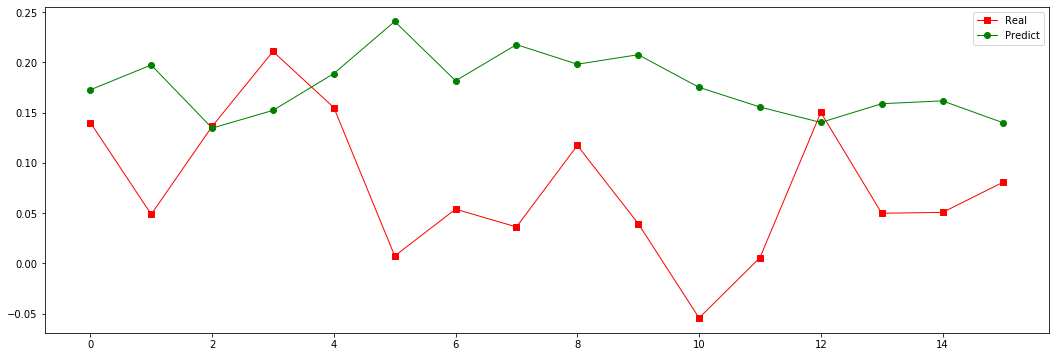

In [130]:
t = np.arange(len(y_test[3]))
plt.figure(figsize=(18,6))
plt.plot(t, y_pre_train[0],"rs-", linewidth=1, label='Real')
plt.plot(t, y_train[0], 'go-', linewidth=1, label='Predict')
plt.legend()
plt.show()

In [131]:
y_pre_train

array([[[0.14011591],
        [0.04873438],
        [0.13624566],
        ...,
        [0.04981691],
        [0.05065082],
        [0.08088501]],

       [[0.1400376 ],
        [0.04875369],
        [0.13617486],
        ...,
        [0.04983035],
        [0.05066606],
        [0.08086743]],

       [[0.14213724],
        [0.0481803 ],
        [0.13817256],
        ...,
        [0.04939043],
        [0.05025539],
        [0.08132672]],

       ...,

       [[0.06860478],
        [0.06853253],
        [0.06660352],
        ...,
        [0.06503054],
        [0.0654759 ],
        [0.06516682]],

       [[0.06867808],
        [0.06850511],
        [0.06671054],
        ...,
        [0.06500379],
        [0.06544269],
        [0.06517978]],

       [[0.06880842],
        [0.06844999],
        [0.06683838],
        ...,
        [0.06500437],
        [0.0654274 ],
        [0.06521729]]])

In [132]:
y_pred_t_geshi=[]
for i in range(len(y_pre_train)):
    s = []
    for j in y_pre_train[i]:
        s.append(j[0])
    y_pred_t_geshi.append(s)

y_pred_t_geshi




[[0.14011590642069868,
  0.04873438019949569,
  0.13624566054304163,
  0.21087672549912848,
  0.15501077832255125,
  0.007325273347157567,
  0.053904631724137314,
  0.03616788009683543,
  0.11730816157226141,
  0.03952411935490919,
  -0.05443151305791222,
  0.005650551676993264,
  0.15013300073771896,
  0.049816906519924826,
  0.050650819840112465,
  0.0808850050067207],
 [0.14003760359100365,
  0.04875368686682981,
  0.1361748637480834,
  0.21071971501982792,
  0.154914315778434,
  0.007390571106389,
  0.05391799018155115,
  0.03619923050289864,
  0.1172532344551718,
  0.03955083156255292,
  -0.0543039375199309,
  0.005713552383032922,
  0.1500427178534819,
  0.04983035415636454,
  0.050666061399500986,
  0.08086742892545304],
 [0.14213724433300046,
  0.048180300509693116,
  0.138172563991597,
  0.2149329999426419,
  0.15751793208485587,
  0.005654593093853015,
  0.05356480130306573,
  0.03533487122028761,
  0.11881529962914715,
  0.03880657945465042,
  -0.05777905901778374,
  0.00396

In [133]:
y_train

array([[0.17272, 0.19739, 0.13458, ..., 0.15887, 0.16167, 0.13977],
       [0.18162, 0.19278, 0.13499, ..., 0.15213, 0.15729, 0.14233],
       [0.17924, 0.192  , 0.13607, ..., 0.15656, 0.15294, 0.14763],
       ...,
       [0.10531, 0.10971, 0.12791, ..., 0.17645, 0.17724, 0.1507 ],
       [0.10426, 0.11007, 0.12708, ..., 0.18051, 0.16711, 0.15439],
       [0.10716, 0.11548, 0.12562, ..., 0.17995, 0.16816, 0.15551]],
      dtype=float32)

avgacc 94.38126557732618
预测与实际差异RMSE: [0.05905857 0.05960114 0.05848916 0.05619339 0.05670435 0.05876005
 0.05662831 0.05593265 0.05330868 0.05472025 0.05591674 0.05550723
 0.05346984 0.05494854 0.05480274 0.05495586]


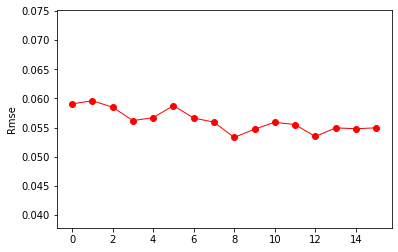

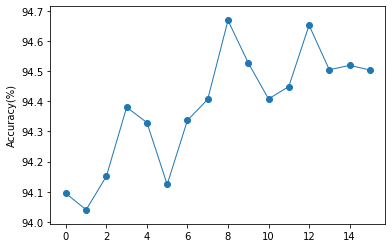

In [134]:
#模型评估
a = (sum(pow((y_pred_t_geshi - y_train),2))/len(y_pred_t_geshi))**0.5
print('avgacc',(1-np.mean(a))*100)
print('预测与实际差异RMSE:',a)
t = np.arange(len(a))
# plt.figure(figsize=(18,6))
plt.scatter(t,a,color = 'r')
plt.plot(t, a,"-",color='r', linewidth=1)
plt.ylabel('Rmse')

# plt.plot(t, y_test_predict[40], 'go-', linewidth=1, label='Predict')
# plt.legend()
plt.show()
tt = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,]
acc = (tt - a)*100
acc
plt.scatter(t,acc)
plt.plot(t, acc,"-", linewidth=1)
plt.ylabel('Accuracy(%)')
# plt.legend()
plt.show()
# print('预测与实际差异RMSE:',(sum(pow((y_test_predict - real_y),2))/y_test_predict.shape[0])**0.5)

In [135]:
len(y_pre)
len(y_test)

1440

In [136]:
y_test_pre_geshi=[]
# y_pred_t_geshi=[]
for i in range(len(y_test)):
    s = []
    for j in y_pre_train[i]:
        s.append(j[0])
    y_test_pre_geshi.append(s)

len(y_test_pre_geshi)




1440

avgacc 60.90135161191482
预测与实际差异RMSE: [0.28757827 0.30455323 0.32267042 0.33674512 0.35012104 0.36479571
 0.37786033 0.38956397 0.40253991 0.41220773 0.4233608  0.43304209
 0.44642085 0.45788653 0.46908139 0.47735635]


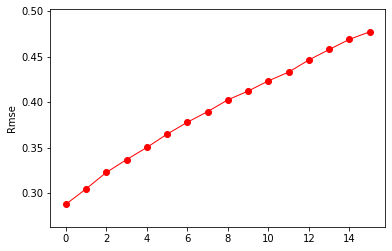

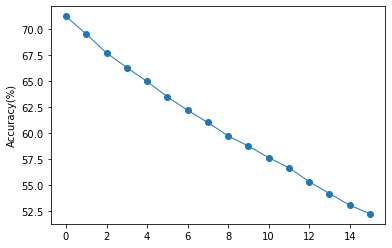

In [138]:
#模型评估
a = (sum(pow((y_test_pre_geshi - y_test),2))/len(y_test_pre_geshi))**0.5
print('avgacc',(1-np.mean(a))*100)
print('预测与实际差异RMSE:',a)
t = np.arange(len(a))
# plt.figure(figsize=(18,6))
plt.scatter(t,a,color = 'r')
plt.plot(t, a,"-",color='r', linewidth=1)
plt.ylabel('Rmse')

# plt.plot(t, y_test_predict[40], 'go-', linewidth=1, label='Predict')
# plt.legend()
plt.show()
tt = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,]
acc = (tt - a)*100
acc
plt.scatter(t,acc)
plt.plot(t, acc,"-", linewidth=1)
plt.ylabel('Accuracy(%)')
# plt.legend()
plt.show()
# print('预测与实际差异RMSE:',(sum(pow((y_test_predict - real_y),2))/y_test_predict.shape[0])**0.5)

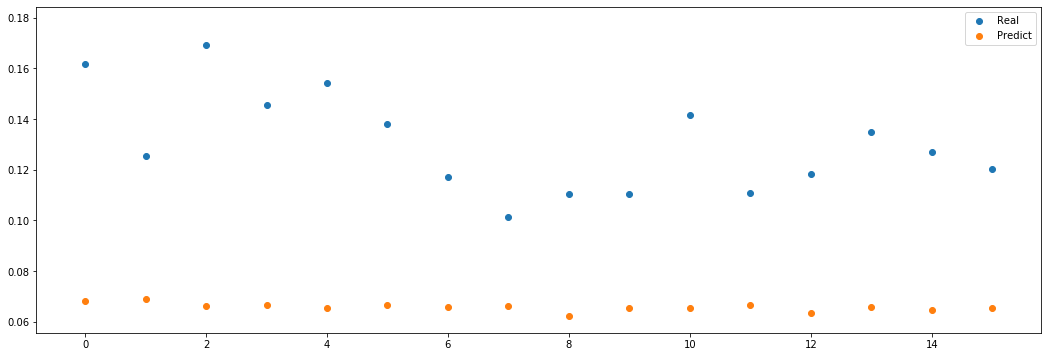

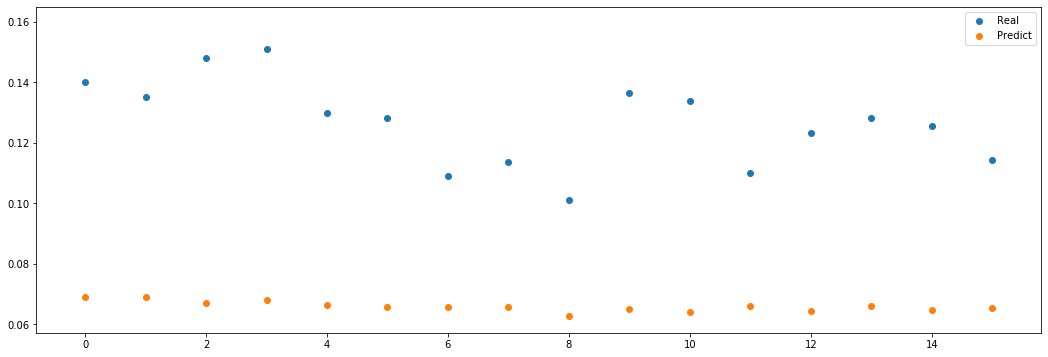

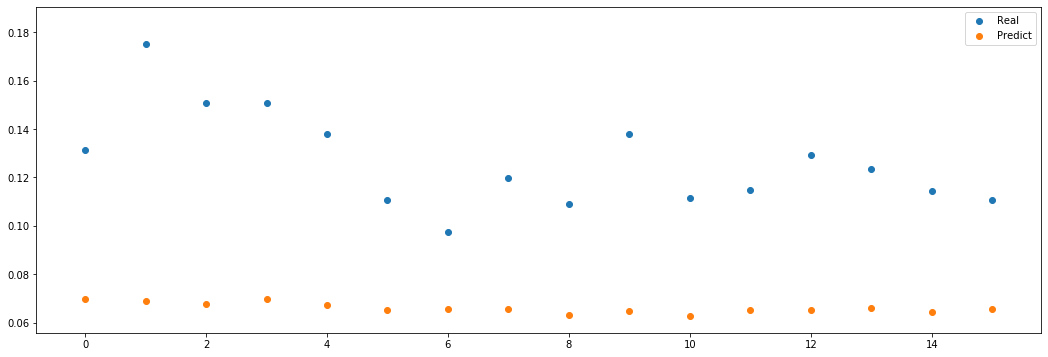

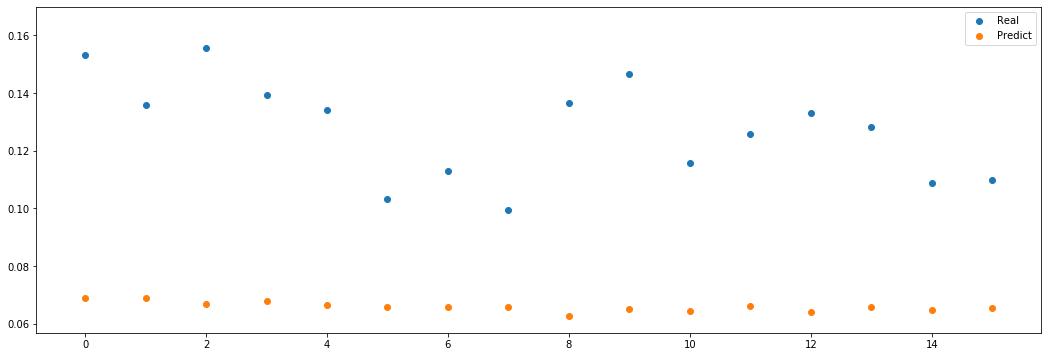

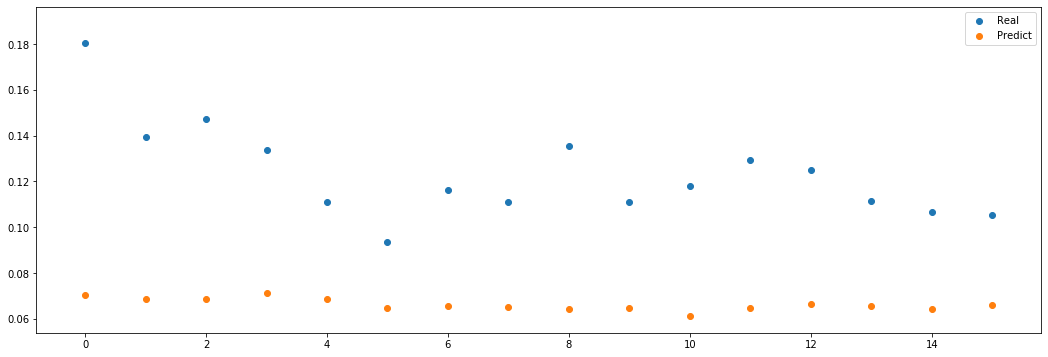

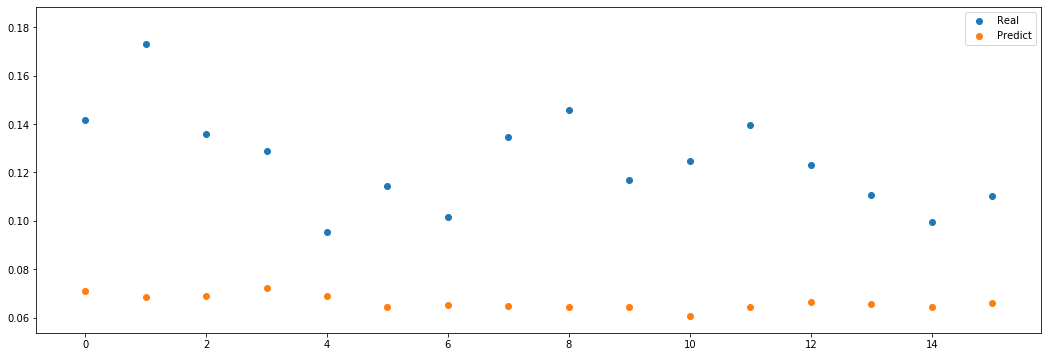

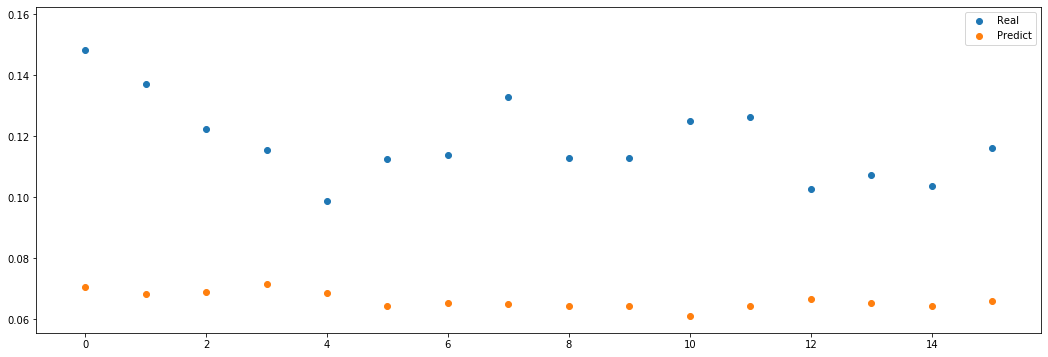

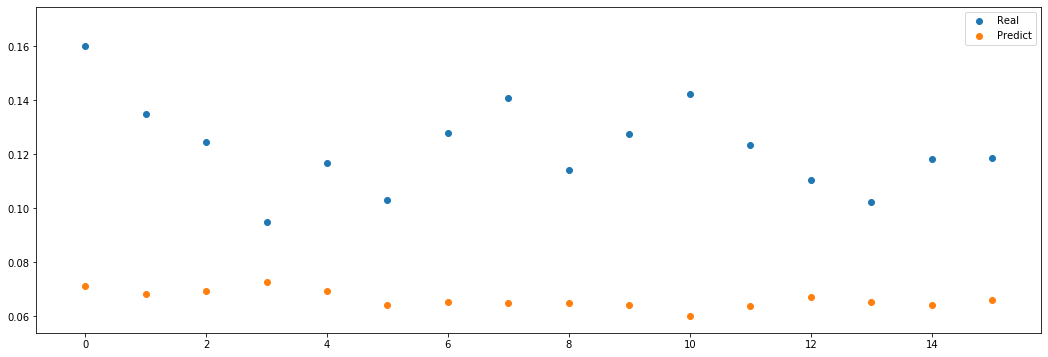

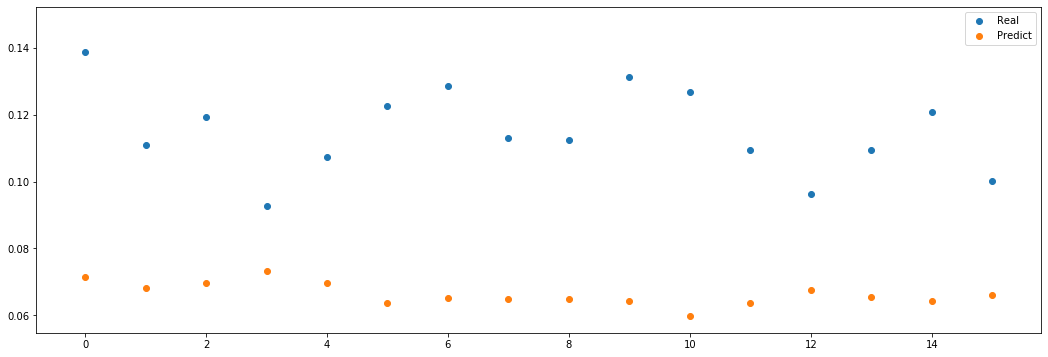

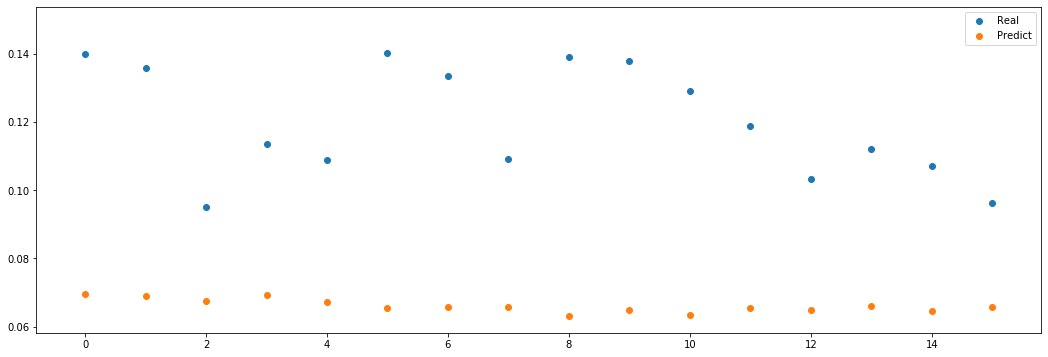

In [139]:

for i in range(20,30):
    t = np.arange(len(y_pred_t_geshi[i*16]))
    plt.figure(figsize=(18,6))
    # plt.plot(t, real_y[i*16],"rs-", linewidth=1, label='Real')
    plt.scatter(t, y_train[i*16], label='Real')
    plt.scatter(t, y_pred_t_geshi[i*16], label='Predict')
    # plt.plot(t, y_test_predict[i*16], 'go-', linewidth=1, label='Predict')
    plt.legend()
    plt.show()